In [40]:
import dtoolcore
import dtoolcore.utils as utils
import time
import numpy as np
import json
import matplotlib.pyplot as plt
import os
import re
from dx_utils import zetta
import glob

In [48]:
rootdir = os.getcwd()

# pat = r'canal_\d+\.\d+_\d+'
pat = r'\d+\.\d+'
path = rootdir+"/dtool_db/"
#print(path)
def get_data_directories(root_dir):
    data_dirs = []
    for root, dirs, files in os.walk(root_dir):
        if root.endswith('/data'):
            data_dirs.append(root)
    return data_dirs

datadir_list = get_data_directories(path)

In [49]:
datadir_list

['/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_0.0_700.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_480.0_580.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_0.0_680.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_0.0_560.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_500.0_580.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_540.0_620.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_600.0_620.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_480.0_540.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_500.0_620.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_480.0

[  0. 460. 480. 500. 520. 540. 560. 580.] [600.]
(8, 1)


/tmp/ipykernel_10400/1246398972.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.linspace(0,2,7).round(2) )


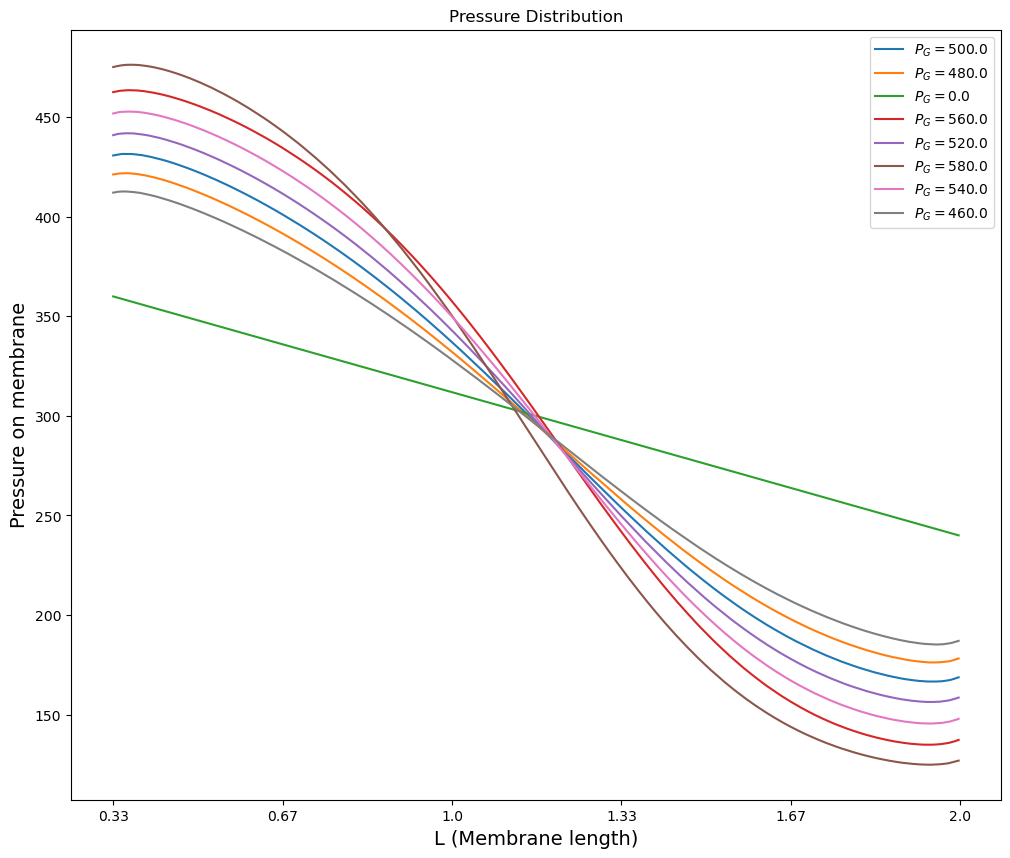

In [11]:
pat = r'\d+\.\d+(?=_)'
pat2 = r'\d+\.\d+(?=/)'

def plot_press(pt, pt2, file, title, yl='Velocity', legend=True, filename="output.pdf"):
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_title(title)
    
    radii_list, press_list = [], []
    
    # First pass: collect unique radii and pressure values
    for i in datadir_list:
        if not re.search(r'600\.0\/data$', i):
            continue
        match, match2 = re.search(pt, i), re.search(pt2, i)
        
        if match and match2:
            radius, pressure = float(match.group()), float(match2.group())
            
            radii_list = radii_list + [radius] if radius not in radii_list else radii_list
            press_list = press_list + [pressure] if pressure not in press_list else press_list


    radii, press = np.sort(np.array(radii_list)), np.sort(np.array(press_list))
    # Create the arr with the correct dimensions
    arr = np.empty((len(radii), len(press)))
    
    # Second pass: fill the arr
    for i in datadir_list:
        if not re.search(r'600\.0\/data$', i):
            continue

        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        u = np.loadtxt(i+file)
        #print(u)
        #u = np.where((u >= -100) & (u <= 100), u, 0)     
        r_index, p_index = np.where(radii == extracted)[0][0], np.where(press == extracted2)[0][0]

        ax.plot(u, label=rf"$P_G={extracted}$")
        arr[r_index, p_index] = np.mean(u)
    print(radii, press)
    print(arr.shape)
    #neg = ax.plot(arr)
    #ax.contour(arr, colors='red')
    ax.set_xticklabels(np.linspace(0,2,7).round(2) )
    #ax.set_yticklabels(radii)
    #fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
    #if legend:
    ax.legend()
    ax.set_ylabel(r'Pressure on membrane', fontsize=14)
    ax.set_xlabel(r'L (Membrane length)', fontsize=14)
    return arr
    fig.savefig("press_dist.pdf", format='pdf', dpi=300, bbox_inches='tight')


arr = plot_press(pat, pat2, "/p_courve_0.32/p_courve.txt", "Pressure Distribution", yl='P delta', legend=True)

In [39]:
from dtoolcore import DataSet
import json

def get_height_from_dtool(dataset_uri):
    ## Dataset-level metadata
    dataset = DataSet.from_uri(dataset_uri)
    
    # Load the dataset
    dataset = DataSet.from_uri(dataset_uri)
    
    # Get the 'metadata' annotation
    metadata = dataset.get_annotation("metadata")
    
    # Print the metadata
    res = metadata[0]
    y = zetta(res["p0"], res["pl"], res["pg"],2,280, num=500)
    
    return np.min(y)


print(get_height_from_dtool("/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_540.0_560.0"))

p0:  336.0082686438839  pg:  540  pl:  224.00726581164102
0.5351327105934243


(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(8, 1)


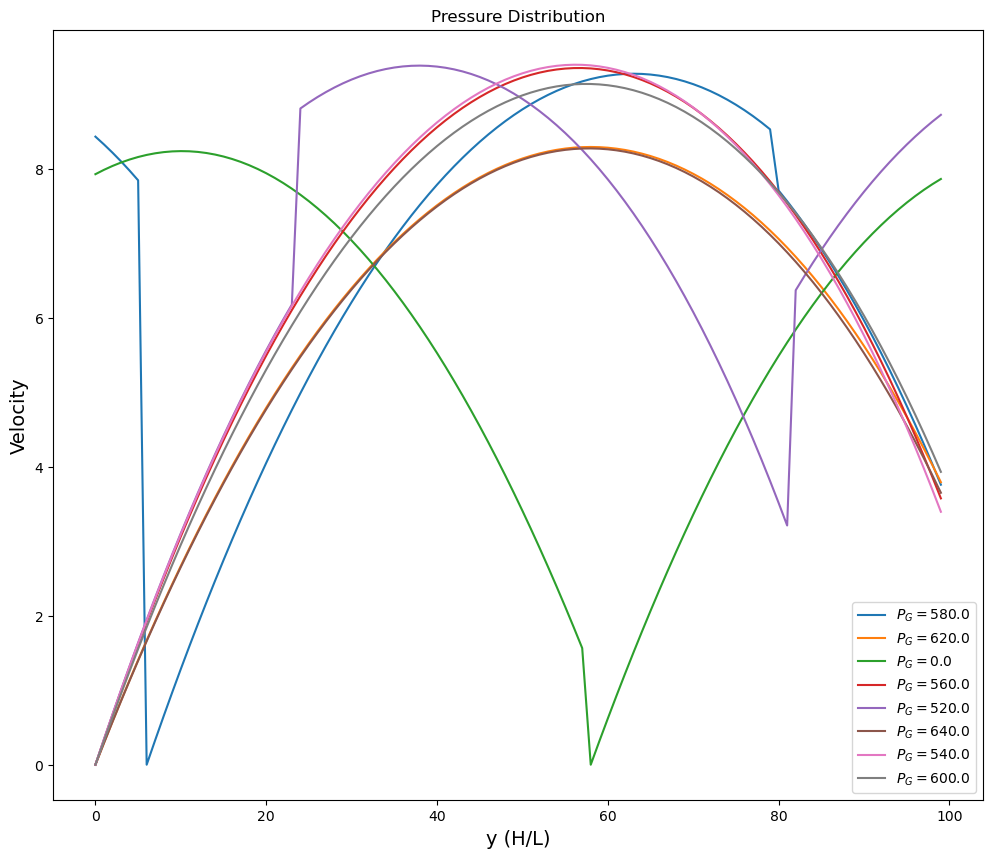

In [50]:
pat = r'\d+\.\d+(?=_)'
pat2 = r'\d+\.\d+(?=/)'

def find_matching_files(directory, pattern):
    regex = re.compile(pattern)
    matching_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if regex.search(os.path.join(root, file)):
                matching_files.append(os.path.join(root, file))
    return matching_files

def plot_press(pt, pt2, file, title, yl='Velocity', legend=True, filename="output.pdf"):
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_title(title)
    
    radii_list, press_list = [], []
    
    # First pass: collect unique radii and pressure values
    for i in datadir_list:
        if not re.search(r'660\.0\/data$', i):
            continue
        match, match2 = re.search(pt, i), re.search(pt2, i)
        
        if match and match2:
            radius, pressure = float(match.group()), float(match2.group())
            
            radii_list = radii_list + [radius] if radius not in radii_list else radii_list
            press_list = press_list + [pressure] if pressure not in press_list else press_list


    radii, press = np.sort(np.array(radii_list)), np.sort(np.array(press_list))
    # Create the arr with the correct dimensions
    arr = np.empty((len(radii), len(press)))
    
    # Second pass: fill the arr
    for i in datadir_list:
        if not re.search(r'660\.0\/data$', i):
            continue

        directory = os.path.dirname(i)
        file_pattern = os.path.basename(file)
        matching_files = find_matching_files(directory, file_pattern)
        
        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        
        file_path = matching_files[0]
        u = np.loadtxt(file_path)
        #print(u)
        #u = np.where((u >= -100) & (u <= 100), u, 0)     
        r_index, p_index = np.where(radii == extracted)[0][0], np.where(press == extracted2)[0][0]
        print(u.shape)
        ax.plot(u[:,0], label=rf"$P_G={extracted}$")
        arr[r_index, p_index] = np.max(u)
    print(arr.shape)

    ax.legend()
    ax.set_ylabel(r'Velocity', fontsize=14)
    ax.set_xlabel(r'y (H/L)', fontsize=14)
    #return arr
    plt.show()
    #fig.savefig("velocity_pofiles.pdf", format='pdf', dpi=300, bbox_inches='tight')


arr = plot_press(pat, pat2, "/y_at_5_.*_0.48/y_at_5_.*.txt", "Pressure Distribution", yl='P delta', legend=True)

In [ ]:
pat = r'\d+\.\d+(?=_)'
pat2 = r'\d+\.\d+(?=/)'

def plot_press(pt, pt2, file, title, yl='Velocity', legend=True, filename="output.pdf"):
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_title(title)
    
    radii_list, press_list = [], []
    
    # First pass: collect unique radii and pressure values
    for i in datadir_list:
        if not re.search(r'700\.0\/data$', i):
            continue
        match, match2 = re.search(pt, i), re.search(pt2, i)
        
        if match and match2:
            radius, pressure = float(match.group()), float(match2.group())
            
            radii_list = radii_list + [radius] if radius not in radii_list else radii_list
            press_list = press_list + [pressure] if pressure not in press_list else press_list


    radii, press = np.sort(np.array(radii_list)), np.sort(np.array(press_list))
    # Create the arr with the correct dimensions
    arr = np.empty((len(radii), len(press)))
    
    # Second pass: fill the arr
    for i in datadir_list:
        if not re.search(r'700\.0\/data$', i):
            continue
        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        u = np.loadtxt(i+file)
        #print(u)
        #u = np.where((u >= -100) & (u <= 100), u, 0)     
        r_index, p_index = np.where(radii == extracted)[0][0], np.where(press == extracted2)[0][0]
        print(u.shape)
        ax.plot(u[:,0], label=rf"$P_G={extracted}$")
        arr[r_index, p_index] = np.max(u)
    #print(radii, press)
    print(arr.shape)
    #neg = ax.plot(arr)
    #ax.contour(arr, colors='red')
    #ax.set_xticklabels(np.linspace(0,2,7).round(2) )
    #ax.set_yticklabels(radii)
    #fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
    #if legend:
    ax.legend()
    ax.set_ylabel(r'Velocity', fontsize=14)
    ax.set_xlabel(r'y (H/L)', fontsize=14)
    #return arr
    fig.savefig("velocity_pofiles.pdf", format='pdf', dpi=300, bbox_inches='tight')


arr = plot_press(pat, pat2, "/y_at_0_0.48/y_at_0.txt", "Pressure Distribution", yl='P delta', legend=True)

500.0 3.6907454607
480.0 3.8787343055
0.0 4.9566701512
560.0 3.0428701463
520.0 3.4857439832
580.0 2.8059222536
540.0 3.2644932183
460.0 4.0510373833
(8, 1)


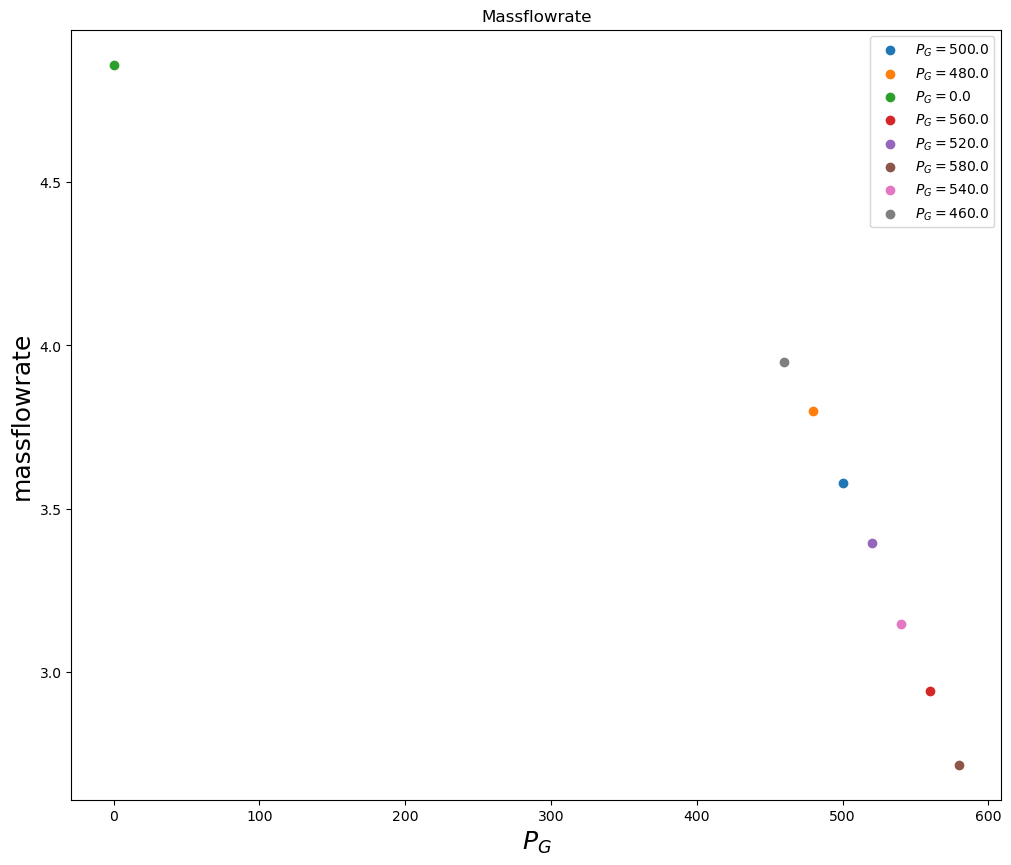

In [16]:
pat = r'\d+\.\d+(?=_)'
pat2 = r'\d+\.\d+(?=/)'
import time

def plot_press1(pt, pt2, file, title, yl='Velocity', legend=True, filename="output.pdf"):
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_title(title)
    
    radii_list, press_list = [], []
    
    # First pass: collect unique radii and pressure values
    for i in datadir_list:
        if not re.search(r'600\.0\/data$', i):
            continue
        match, match2 = re.search(pt, i), re.search(pt2, i)
        
        if match and match2:
            radius, pressure = float(match.group()), float(match2.group())
            
            radii_list = radii_list + [radius] if radius not in radii_list else radii_list
            press_list = press_list + [pressure] if pressure not in press_list else press_list


    radii, press = np.sort(np.array(radii_list)), np.sort(np.array(press_list))
    # Create the arr with the correct dimensions
    arr = np.empty((len(radii), len(press)))
    
    # Second pass: fill the arr
    for i in datadir_list:
        if not re.search(r'600\.0\/data$', i):
            continue
        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        u = np.loadtxt(i+file)
        time.sleep(.01)
        #u = np.where((u >= -100) & (u <= 100), u, 0)     
        #r_index, p_index = np.where(radii == extracted)[0][0], np.where(press == extracted2)[0][0]
        #print(u.shape)
        print(float(extracted), u[0])
        ax.scatter(float(extracted), u[1], label=rf"$P_G={extracted}$")
        #ax.plot(u)
        #arr[r_index, p_index] = u[0] # np.mean(u)
    
    #print(radii, press)
    print(arr.shape)
    #neg = ax.imshow(arr)
    #ax.contour(arr, colors='red')
    #ax.set_xticklabels(np.linspace(0,2,7).round(2) )
    #ax.set_yticklabels(radii)
    #fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
    #if legend:
    ax.legend()
    ax.set_ylabel(r'massflowrate', fontsize=18)
    ax.set_xlabel(r'$P_G$', fontsize=18)
    #return arr
    fig.savefig("mass_flow.pdf", format='pdf', dpi=300, bbox_inches='tight')


arr2 = plot_press1(pat, pat2, "/flux_trapz_0.48/flux_trapz.txt", "Massflowrate", yl='P delta', legend=True)

In [81]:
print(arr)

[[ 6.94489500e-310  6.94489500e-310  4.64449359e-310  3.56266807e-001
   4.94065646e-324  4.94065646e-324]
 [-1.44010667e+304 -2.12561252e+304 -3.29167444e+304              nan
   2.18007543e-106              nan]
 [ 1.01077333e-274  1.23387897e-178              nan  3.95252517e-323
   7.29111892e-304  1.18168601e-125]
 [ 1.59451272e-202 -1.78272453e+304  6.94487147e-310  2.95034546e-001
   6.94487145e-310  4.64445799e-310]
 [ 6.94487147e-310  4.64445799e-310  6.94488128e-310  6.94485431e-310
   6.94488234e-310  6.94485302e-310]
 [ 6.94487146e-310  4.64445799e-310  6.94487146e-310  4.64445799e-310
   6.94487146e-310  4.64445799e-310]
 [ 6.94487146e-310  0.00000000e+000  6.94487147e-310  4.64445799e-310
   6.94487146e-310  4.64445799e-310]
 [ 6.94487147e-310  4.64445799e-310  6.94488122e-310  4.64445799e-310
   6.94487146e-310              nan]
 [ 6.94487146e-310  4.64445799e-310  6.94487146e-310  4.64445799e-310
   6.94487146e-310  4.64445799e-310]
 [ 6.94488240e-310  6.94485432e-310  

(8, 1)


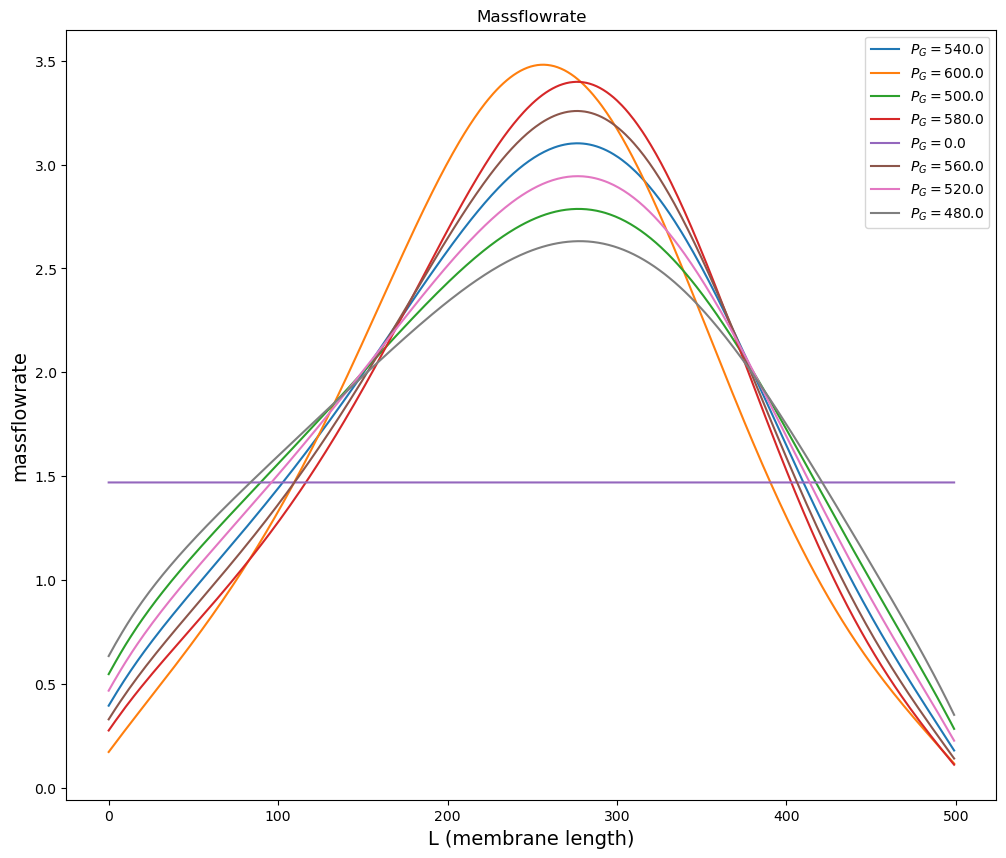

In [18]:
pat = r'\d+\.\d+(?=_)'
pat2 = r'\d+\.\d+(?=/)'
import time

def plot_press2(pt, pt2, file, title, yl='Velocity', legend=True, filename="output.pdf"):
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_title(title)
    
    radii_list, press_list = [], []
    
    # First pass: collect unique radii and pressure values
    for i in datadir_list:
        if not re.search(r'620\.0\/data$', i):
            continue
        match, match2 = re.search(pt, i), re.search(pt2, i)
        
        if match and match2:
            radius, pressure = float(match.group()), float(match2.group())
            
            radii_list = radii_list + [radius] if radius not in radii_list else radii_list
            press_list = press_list + [pressure] if pressure not in press_list else press_list


    radii, press = np.sort(np.array(radii_list)), np.sort(np.array(press_list))
    # Create the arr with the correct dimensions
    arr = np.empty((len(radii), len(press)))
    
    # Second pass: fill the arr
    for i in datadir_list:
        if not re.search(r'620\.0\/data$', i):
            continue
        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        u = np.loadtxt(i+file)
        time.sleep(.01)
        #u = np.where((u >= -100) & (u <= 100), u, 0)     
        #r_index, p_index = np.where(radii == extracted)[0][0], np.where(press == extracted2)[0][0]
        #print(u.shape)
        ax.plot(u[:,0], label=rf"$P_G={extracted}$")
        #arr[r_index, p_index] = u[0] # np.mean(u)
    
    #print(radii, press)
    print(arr.shape)
    #neg = ax.imshow(arr)
    #ax.contour(arr, colors='red')
    #ax.set_xticklabels(np.linspace(0,2,7).round(2) )
    #ax.set_yticklabels(radii)
    #fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
    #if legend:
    ax.legend()
    ax.set_ylabel(r'massflowrate', fontsize=14)
    ax.set_xlabel(r'L (membrane length)', fontsize=14)
    return arr
    #fig.savefig("press_dist.pdf", format='pdf', dpi=300, bbox_inches='tight')


arr2 = plot_press2(pat, pat2, "/y_courve_0.64/y_courve.txt", "Massflowrate", yl='P delta', legend=True)

In [51]:
data_string = """
7.8690361555e+00 1.0179544043e-05
7.9267987382e+00 1.0970413955e-05
7.9785663309e+00 8.5600316090e-06
8.0243061199e+00 3.1628799501e-06
8.0639801657e+00 -1.3496831673e-06
8.0976617842e+00 -3.0877314091e-06
8.1253451688e+00 -2.6439884312e-06
8.1470178480e+00 -4.5365398852e-06
8.1626813633e+00 -7.4404357229e-06
8.1723227935e+00 -7.3209102863e-06
8.1759891311e+00 -5.6813385285e-06
8.1736158558e+00 -2.5403209069e-06
8.1652220235e+00 -1.5712233021e-06
8.1508326658e+00 -5.3173248360e-06
8.1304215737e+00 -1.0296469597e-05
8.1040040708e+00 -1.2779370113e-05
8.0715835339e+00 -1.3028953807e-05
8.0331469623e+00 -1.2759531310e-05
7.9886963750e+00 -1.2945521583e-05
7.9382380951e+00 -1.3236633663e-05
7.8817715966e+00 -1.3242611848e-05
7.8192818856e+00 -1.3552108556e-05
7.7507852176e+00 -1.3352744440e-05
7.6762717822e+00 -1.3526989066e-05
7.5957293056e+00 -1.3459978277e-05
7.5091848429e+00 -1.3416419417e-05
7.4166206472e+00 -1.3784265010e-05
7.3180425855e+00 -1.4287215571e-05
7.2134496927e+00 -1.4928455767e-05
7.1028216434e+00 -1.5372214898e-05
6.9861827403e+00 -1.5707735339e-05
6.8635322201e+00 -1.5968184040e-05
6.7348301548e+00 -1.5321436489e-05
6.6001323354e+00 -1.3686228738e-05
6.4594063124e+00 -1.3038345865e-05
6.3126349062e+00 -1.3363573774e-05
6.1598427614e+00 -1.3302912379e-05
6.0010284205e+00 -1.2243363735e-05
5.8361823989e+00 -1.1044466277e-05
5.6652963443e+00 -9.6319215698e-06
5.4883801246e+00 -8.1941299635e-06
5.3054341827e+00 -6.6888833295e-06
5.1164419180e+00 -5.9716128057e-06
4.9214006125e+00 -6.3885727868e-06
4.7203362321e+00 -6.5521681709e-06
4.5132205585e+00 -5.6886538149e-06
4.3000584320e+00 -3.9042040964e-06
4.0808603249e+00 -2.7098748754e-06
3.8556139941e+00 -2.8114308234e-06
3.6243170436e+00 -3.8197865190e-06
3.3869695909e+00 -4.3299903633e-06
3.1435608067e+00 -3.9506524499e-06
2.8941090056e+00 -2.3755098072e-06
2.6385919723e+00 -1.5937887177e-06
2.3770150179e+00 -1.4678169533e-06
2.1093809712e+00 -1.5129592871e-06
1.8356838028e+00 -1.3711432973e-06
1.5559215186e+00 -9.5875491502e-07
-8.5008770208e-06 5.5847834198e-11
3.1139769413e-01 -2.1133806261e-07
6.1672446955e-01 -2.8319547881e-07
9.1597406918e-01 -2.4256485362e-07
1.2091552930e+00 -7.9585618322e-09
1.4962677613e+00 4.8502971478e-07
1.7773084908e+00 8.7051078023e-07
2.0522785485e+00 8.5994864937e-07
2.3211991123e+00 9.2361286267e-07
2.5840504095e+00 1.2498899217e-06
2.8408411377e+00 1.7502464796e-06
3.0915781522e+00 2.1824657581e-06
3.3362545285e+00 2.5114794650e-06
3.5748788977e+00 2.7751107761e-06
3.8074540556e+00 2.8649411900e-06
4.0339800384e+00 2.7758106869e-06
4.2544562106e+00 2.9560888255e-06
4.4688863594e+00 3.7069269222e-06
4.6772721282e+00 4.9062351218e-06
4.8796142819e+00 5.7784365724e-06
5.0759105466e+00 6.1955728678e-06
5.2661759195e+00 6.1277957784e-06
5.4503977739e+00 6.4478940651e-06
5.6285678774e+00 7.1008099265e-06
5.8007313667e+00 7.9569765209e-06
5.9668558955e+00 8.5021753395e-06
6.1269398282e+00 8.6794780433e-06
6.2810027402e+00 8.7215908488e-06
6.4290362795e+00 9.0227619281e-06
6.5710355033e+00 9.2574448979e-06
6.7070072801e+00 9.0742118994e-06
6.8369572972e+00 8.6165966108e-06
6.9608890050e+00 7.6955217162e-06
7.0787985973e+00 6.7990348711e-06
7.1906855802e+00 5.8494855923e-06
7.2965439438e+00 5.6307098470e-06
7.3963900612e+00 5.2825637432e-06
7.4902206151e+00 5.0061700216e-06
7.5780295326e+00 4.2567034187e-06
7.6597924507e+00 3.9482333159e-06
7.7355484197e+00 4.3618697815e-06
7.8052996183e+00 6.5509716303e-06"""
lines = [line.strip() for line in data_string.split('\n') if line.strip()]

# Convert each line to a list of floats
data = [list(map(float, line.split())) for line in lines]

# Create a NumPy array from the list of lists
arr = np.array(data)

print(arr)

[[ 7.86903616e+00  1.01795440e-05]
 [ 7.92679874e+00  1.09704140e-05]
 [ 7.97856633e+00  8.56003161e-06]
 [ 8.02430612e+00  3.16287995e-06]
 [ 8.06398017e+00 -1.34968317e-06]
 [ 8.09766178e+00 -3.08773141e-06]
 [ 8.12534517e+00 -2.64398843e-06]
 [ 8.14701785e+00 -4.53653989e-06]
 [ 8.16268136e+00 -7.44043572e-06]
 [ 8.17232279e+00 -7.32091029e-06]
 [ 8.17598913e+00 -5.68133853e-06]
 [ 8.17361586e+00 -2.54032091e-06]
 [ 8.16522202e+00 -1.57122330e-06]
 [ 8.15083267e+00 -5.31732484e-06]
 [ 8.13042157e+00 -1.02964696e-05]
 [ 8.10400407e+00 -1.27793701e-05]
 [ 8.07158353e+00 -1.30289538e-05]
 [ 8.03314696e+00 -1.27595313e-05]
 [ 7.98869637e+00 -1.29455216e-05]
 [ 7.93823810e+00 -1.32366337e-05]
 [ 7.88177160e+00 -1.32426118e-05]
 [ 7.81928189e+00 -1.35521086e-05]
 [ 7.75078522e+00 -1.33527444e-05]
 [ 7.67627178e+00 -1.35269891e-05]
 [ 7.59572931e+00 -1.34599783e-05]
 [ 7.50918484e+00 -1.34164194e-05]
 [ 7.41662065e+00 -1.37842650e-05]
 [ 7.31804259e+00 -1.42872156e-05]
 [ 7.21344969e+00 -1

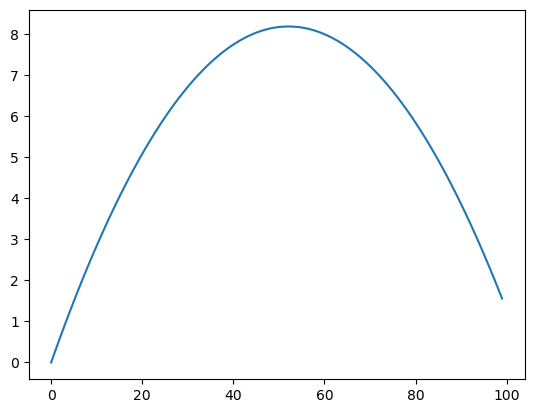

In [60]:

min_index = np.argmin(np.abs(arr[:,0]))
rolled_back = np.roll(arr[:,0], -min_index)
plt.plot(rolled_back)